In [1]:
%load_ext autoreload
%autoreload 2
import sys 
sys.path.append('src/')

In [2]:
from typing import List
import torch
from torch import nn
from torch.utils.data import RandomSampler, DataLoader
import numpy as np

from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from torchvision.utils import make_grid

from dasbm.data import DiscreteGaussianDataset, DiscreteSwissRollDataset, DiscreteColoredMNISTDataset, Prior
from dasbm.models.toy import DiffusionModel, D3PM
from dasbm.models.images import ImageD3PM
from dasbm.models.vq import VQDiffusion
from dasbm.trainer import DiscreteSBMTrainer
from dasbm.utils import visualize, visualize_trajectory

# Toy

In [6]:
def train(
    d3pm: D3PM, 
    sampler_end: Sampler, 
    sampler_start: Sampler, 
    epochs: int, 
    inner_steps: int, 
    batch_size: int,
    optimizer: torch.optim.Optimizer, 
):
    for epoch in range(1, epochs + 1):
        d3pm.train()
        for inner_step in tqdm(range(1, inner_steps + 1), desc=f'Epoch: {epoch}'):
            optimizer.zero_grad()
            true_x_start = sampler_start.sample(batch_size).to(d3pm.device)
            t = torch.randint(1, d3pm.num_timesteps + 2, (true_x_start.shape[0],), device=d3pm.device)
            x_t = d3pm.prior.sample(true_x_start, t)
            
            # KL-divergence calculation
            pred_x_start_logits = d3pm(x_t, t)
            true_q_posterior_logits = d3pm.prior.q_posterior_logits(true_x_start, x_t, t) # .flatten(start_dim=0, end_dim=-2)
            pred_q_posterior_logits = d3pm.prior.q_posterior_logits(pred_x_start_logits, x_t, t) # .flatten(start_dim=0, end_dim=-2)
    
            kl_loss = torch.softmax(true_q_posterior_logits + d3pm.eps, dim=-1) * (
                torch.log_softmax(true_q_posterior_logits + d3pm.eps, dim=-1)
                - torch.log_softmax(pred_q_posterior_logits + d3pm.eps, dim=-1)
            )
            kl_loss = kl_loss.sum(dim=-1).mean()
            # Cross-Entropy calculation
            pred_x_start_logits = pred_x_start_logits.flatten(start_dim=0, end_dim=-2)
            true_x_start = true_x_start.flatten(start_dim=0, end_dim=-1)
            
            ce_loss = torch.nn.CrossEntropyLoss()(pred_x_start_logits, true_x_start)
    
            loss = kl_loss + d3pm.ce_loss_coeff * ce_loss
            info = {
                "kl_loss": kl_loss.detach().item(),
                "ce_loss": ce_loss.detach().item(),
            }
            loss.backward()
            torch.nn.utils.clip_grad_norm_(d3pm.model.parameters(), 0.01)
            optimizer.step()
    
        print(f'kl_loss: {info["kl_loss"]}, ce_loss: {info["ce_loss"]}')
        d3pm.eval()
        test_x_end = sampler_end.sample(1024).to(d3pm.device)
        test_x_start = sampler_start.sample(1024).to(d3pm.device)
        pred_x_start = d3pm.sample(test_x_end)
        visualize(test_x_end, test_x_start, pred_x_start)
        visualize_trajectory(test_x_end, d3pm)

In [11]:
# DASBM params
alpha = 0.1

# Model params
input_dim = 2
num_categories = 50
num_timesteps = 100

#Training params
epochs = 5
inner_steps = 10_000
batch_size = 128
lr = 4e-4
device = 'cuda'

Epoch: 1:   0%|          | 0/500 [00:00<?, ?it/s]

kl_loss: 0.09601887245826385, ce_loss: 3.785219192504883


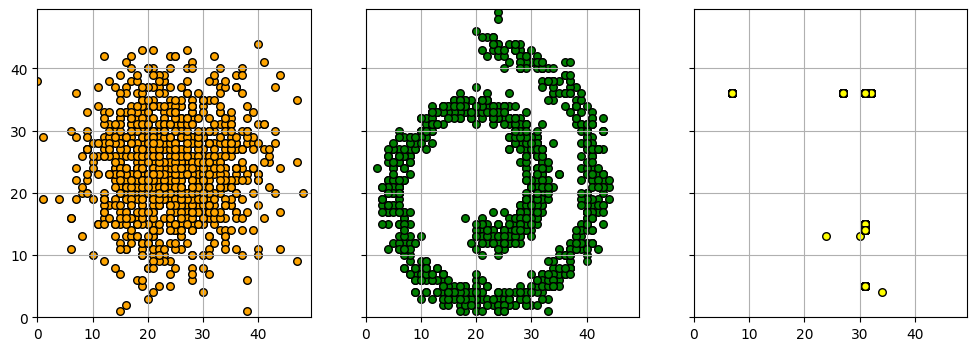

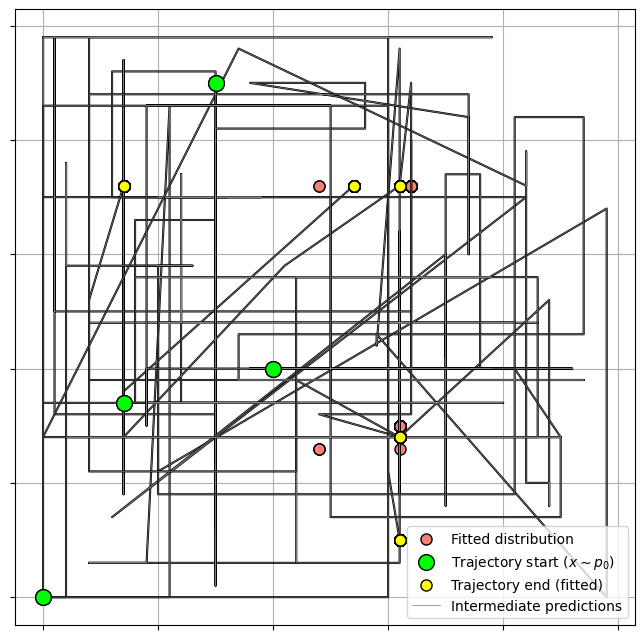

Epoch: 2:   0%|          | 0/500 [00:00<?, ?it/s]

kl_loss: 0.14302298163681065, ce_loss: 3.8200860023498535


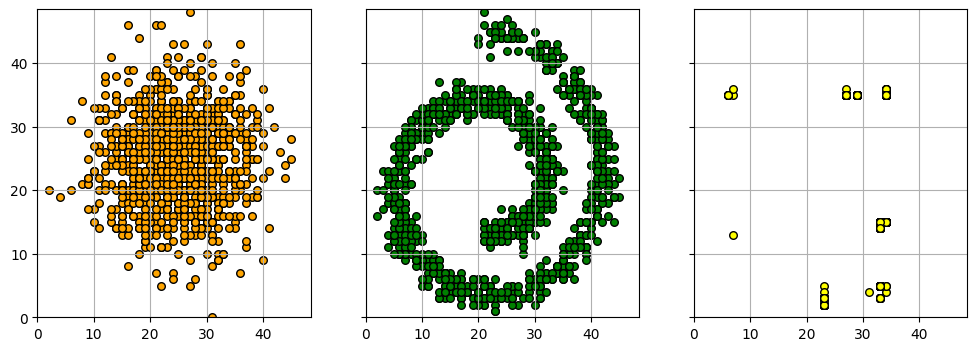

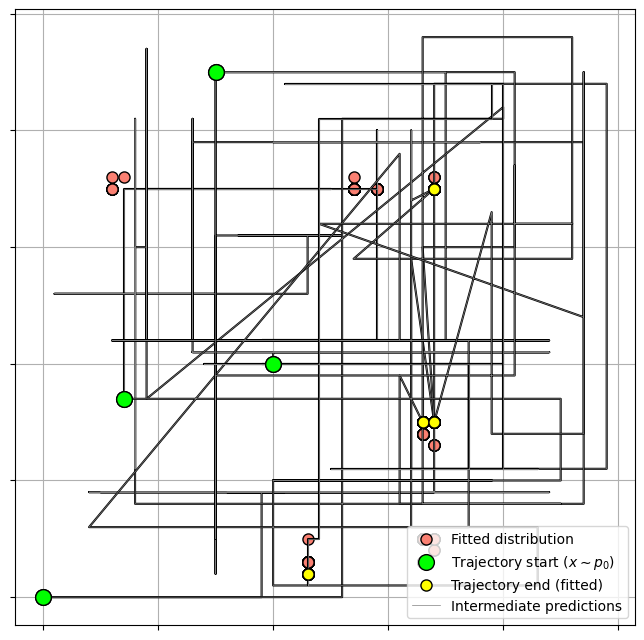

Epoch: 3:   0%|          | 0/500 [00:00<?, ?it/s]

kl_loss: 0.07652379966982961, ce_loss: 3.7939445972442627


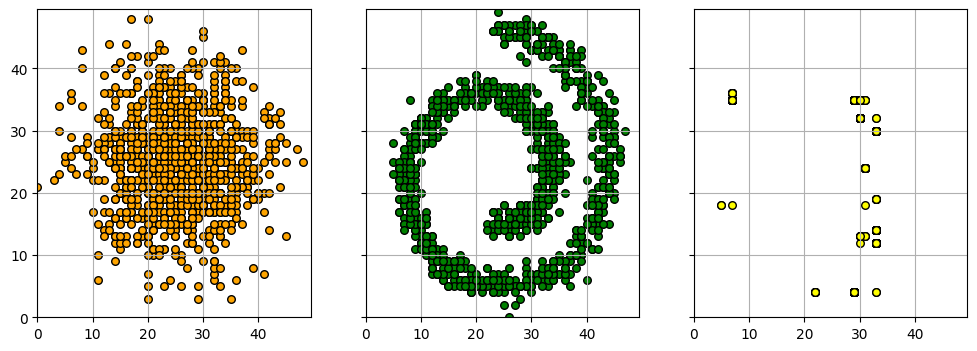

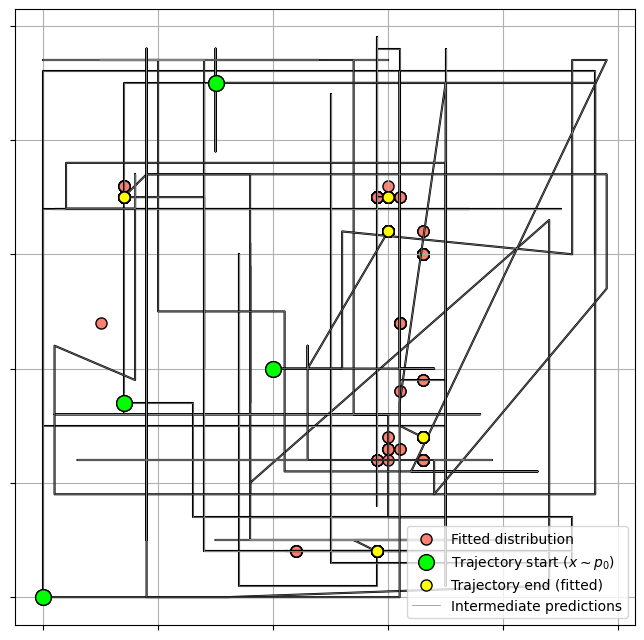

Epoch: 4:   0%|          | 0/500 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [12]:
model = DiffusionModel(input_dim, num_categories, num_timesteps)
prior = Prior(alpha, num_categories, num_timesteps)
d3pm = D3PM(model, prior, num_categories, num_timesteps).to(device)

optimizer = torch.optim.AdamW(d3pm.parameters(), lr=lr, betas=(0.95, 0.99))

gaussian_sampler = DiscreteGaussianSampler(dim=2, num_categories=num_categories)
swiss_roll_sampler = DiscreteSwissRollSampler(num_categories=num_categories)

train(
    d3pm, 
    sampler_end=gaussian_sampler, 
    sampler_start=swiss_roll_sampler, 
    epochs=epochs, 
    inner_steps=inner_steps, 
    batch_size=batch_size, 
    optimizer=optimizer, 
)

## Test DiscreteSBM

In [1]:
# DASBM params
alpha = 0.1

# Model params
input_dim = 2
num_categories = 50
num_timesteps = 100

#Training params
iterations = 5
inner_iterations = 10_000
batch_size = 512
lr = 4e-4
device = 'cuda'

In [6]:
prior = Prior(alpha, num_categories, num_timesteps)
forward_d3pm = D3PM(
    DiffusionModel(input_dim, num_categories, num_timesteps), 
    prior, 
).to(device)

backward_d3pm = D3PM(
    DiffusionModel(input_dim, num_categories, num_timesteps), 
    prior, 
).to(device)

forward_optimizer = torch.optim.AdamW(forward_d3pm.parameters(), lr=lr, betas=(0.95, 0.99))
backward_optimizer = torch.optim.AdamW(backward_d3pm.parameters(), lr=lr, betas=(0.95, 0.99))

gaussian_sampler = DiscreteGaussianSampler(dim=2, num_categories=num_categories)
swiss_roll_sampler = DiscreteSwissRollSampler(num_categories=num_categories)

trainer = DiscreteSBMTrainer(
    iterations,
    inner_iterations,
    forward_d3pm,
    backward_d3pm,
    forward_optimizer,
    backward_optimizer
)
trainer.train(batch_size, gaussian_sampler, swiss_roll_sampler)

TypeError: DiscreteSBMTrainer.__init__() missing 1 required positional argument: 'exp_path'

MovieWriter ffmpeg unavailable; using Pillow instead.


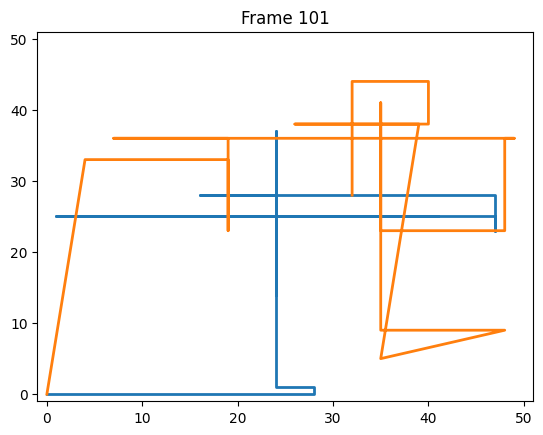

In [70]:
fig, ax = plt.subplots()
num_trajectories = 2
test_sample = torch.zeros(size=[num_trajectories, 2], device=device, dtype=torch.int)
trajectory = forward_d3pm.sample_trajectory(test_sample).cpu().numpy()

lines = [ax.plot([], [], lw=2) for _ in range(num_trajectories)]
ax.set(xlim=[-1, 51], ylim=[-1, 51])

def animate(n):
    ax.set_title(f'Frame {n}')
    for i, line in enumerate(lines):
        line[0].set_xdata(trajectory[:n, i, 0])
        line[0].set_ydata(trajectory[:n, i, 1])
    return lines

anim = FuncAnimation(fig, animate, frames=trajectory.shape[0], interval=100)
anim.save('discrete_bm.gif')
plt.show()

MovieWriter ffmpeg unavailable; using Pillow instead.


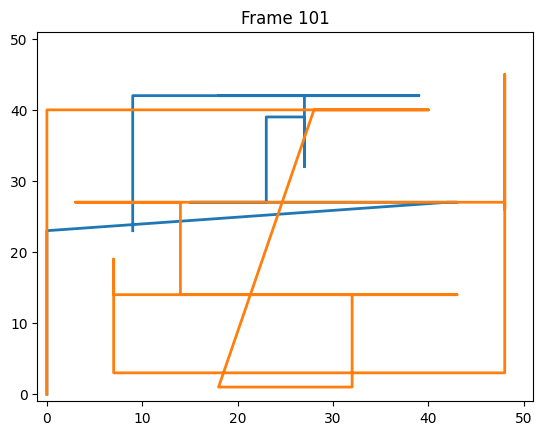

In [71]:
fig, ax = plt.subplots()
num_trajectories = 2
test_sample = torch.zeros(size=[num_trajectories, 2], device=device, dtype=torch.int)
trajectory = d3pm.sample_trajectory(test_sample).cpu().numpy()

lines = [ax.plot([], [], lw=2) for _ in range(num_trajectories)]
ax.set(xlim=[-1, 51], ylim=[-1, 51])

def animate(n):
    ax.set_title(f'Frame {n}')
    for i, line in enumerate(lines):
        line[0].set_xdata(trajectory[:n, i, 0])
        line[0].set_ydata(trajectory[:n, i, 1])
    return lines

anim = FuncAnimation(fig, animate, frames=trajectory.shape[0], interval=100)
anim.save('d3pm.gif')
plt.show()

# Images

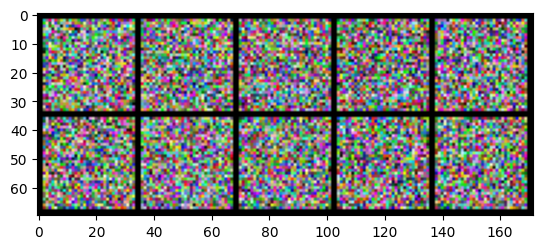

In [47]:
dataset = DiscreteColoredMNISTDataset(target_digit=2)
image = dataset[:10].cuda()
time = torch.randint(0, 100, size=(10,)).cuda()

model = ImageD3PM().cuda()
prior = Prior(256, 100, 'gaussian_linear').to('cuda')
plt.imshow(make_grid(model.sample(image, prior).cpu(), nrow=5).permute(1, 2, 0))

In [66]:
batch_size, inner_iterations = 4, 10
forward_d3pm = ImageD3PM().cuda()
backward_d3pm = ImageD3PM().cuda()
forward_optimizer = torch.optim.AdamW(forward_d3pm.parameters(), lr=1e-4, betas=(0.95, 0.99)) # type: ignore
backward_optimizer = torch.optim.AdamW(backward_d3pm.parameters(), lr=1e-4, betas=(0.95, 0.99)) # type: ignore

n_samples = batch_size * inner_iterations
dataset_x = DiscreteColoredMNISTDataset(target_digit=2)
dataset_y = DiscreteColoredMNISTDataset(target_digit=3)

dataloader_x = DataLoader(
    dataset_x, 
    sampler=RandomSampler(
        dataset_x, 
        replacement=True, 
        num_samples=n_samples
    ), 
    batch_size=batch_size
)
dataloader_y = DataLoader(
    dataset_y, 
    sampler=RandomSampler(
        dataset_y, 
        replacement=True, 
        num_samples=n_samples
    ), 
    batch_size=batch_size
)

trainer = DiscreteSBMTrainer(
    iterations=2,
    forward_model=forward_d3pm,
    backward_model=backward_d3pm,
    prior=prior,
    forward_optimizer=forward_optimizer,
    backward_optimizer=backward_optimizer,
    kl_loss_coeff=1,
    ce_loss_coeff=0.001,
    exp_type='images',
    exp_path='',
    eval_freq=10,
    eval_samples=9
)

In [ ]:
trainer.train(dataloader_x, dataloader_y)

# VQ

In [3]:
content_emb_config = {
    'num_embed': 512,
    'spatial_size': [32, 32],
    'embed_dim': 512,
    'trainable': True,
    'pos_emb_type': 'embedding',
}

In [4]:
vq = VQDiffusion(
    attn_type='self',
    n_layer=20,
    content_seq_len=256,  # 16 x 16,
    content_spatial_size=[16, 16],
    n_embd=512, # the dim of embedding dims   # both this and content_emb_config,
    n_head=16,
    attn_pdrop=0,
    resid_pdrop=0,
    block_activate='GELU2',
    timestep_type='adalayernorm',    # adainsnorm or adalayernorm and abs,
    mlp_hidden_times=4,
    mlp_type='conv_mlp',
    content_emb_config=content_emb_config
)

In [5]:
t = torch.randint(
    low=1, 
    high=100,
    size=(256,), 
).cuda()
x = torch.randint(0, 32, size=(32, 256)).cuda()
print(x)
vq(x, None, t)

tensor([[ 2, 22, 18,  ...,  7, 23, 22],
        [29, 19, 14,  ..., 18, 11, 11],
        [27,  7, 12,  ..., 21,  6,  8],
        ...,
        [29,  5, 18,  ..., 21, 20, 21],
        [ 2, 31, 29,  ..., 17, 23, 30],
        [13, 30, 18,  ..., 15, 24, 18]], device='cuda:0')


RuntimeError: IndexError: index out of range in self, max index 31, num embed 513